**继AlphaFold 大火之后，DeepMind 又一款算法蹿红。12 月 23 日，DeepMind 在官网发表博文 MuZero: Mastering Go, chess, shogi and Atari without rules，并详细介绍了这款名为 MuZero 的 AI 算法。**

![](https://ai-studio-static-online.cdn.bcebos.com/a8c87916f6d048fcbbbbe8233c90d15fb4ba2e459fd340418c4aff0d79d3f29a)
*  AlphaGo 提供了人类知识（Human Knowledge）和规则（Rules），因此可训练出一个大的策略树，来完成搜索、以及帮助做出决策；
*  AlphaGo Zero 去掉了人类知识部分，而是只给 AI 提供规则，然后通过自我博弈，就能学习出自己的策略；
*  AlphaZero 则可通过完全信息，利用泛化能力更强的强化学习算法来做训练，并学会不同的游戏，如围棋、国际象棋和日本将棋。
*  MuZero 则是前级阶段的升级版，即在没有人类知识以及规则的情况下，它能通过分析环境和未知条件（Unknown Dynamics），来进行不同游戏的博弈。



**本项目是一个极简的MuZero的实现，没有使用MCTS方法，模型由Representation_model、Dynamics_Model、Prediction_Model构成：**
* Representation_model将一组观察值映射到神经网络的隐藏状态s；
* 动态Dynamics_Model根据动作a_(t + 1)将状态s_t映射到下一个状态s_(t + 1)，同时估算在此过程的回报r_t，这样模型就能够不断向前扩展；
* 预测Prediction_Model 根据状态s_t对策略p_t和值v_t进行估计；


In [1]:
import gym
import numpy as np
import paddle
import paddle.nn as nn 
import paddle.optimizer as optim
import paddle.nn.functional as F
import copy
import random
from tqdm import tqdm
from collections import deque

env = gym.make('CartPole-v0')
hidden_dims = 128
o_dim = env.observation_space.shape[0]


act_dim  = env.action_space.n

Representation_model= paddle.nn.Sequential(
    paddle.nn.Linear(
        o_dim, 128),
    paddle.nn.ELU(),
    paddle.nn.Linear(128, hidden_dims),
    
    )

# paddle.summary(h, (50,4))

class Dynamics_Model(paddle.nn.Layer):
    # action encoding - one hot
    
    def __init__(self, num_hidden, num_actions): 
        super().__init__()
        
        self.num_hidden = num_hidden
        self.num_actions = num_actions
        network = [
        nn.Linear(self.num_hidden+self.num_actions, self.num_hidden),
        nn.ELU(),
        nn.Linear(self.num_hidden,128),
        ]       
        self.network = nn.Sequential(*network)   
        self.hs =  nn.Linear(128,self.num_hidden)
        self.r =  nn.Linear(128,1)
    def forward(self, hs,a):
        out = paddle.concat(x=[hs, a], axis=-1)
        out = self.network(out)
        hidden =self.hs(out) 
        reward = self.r(out)
        
        
        
        return hidden, reward
# D = Dynamics_Model(hidden_dims,act_dim)
# paddle.summary(D, [(2,hidden_dims),(2,2)])

class Prediction_Model(paddle.nn.Layer):
    
    def __init__(self, num_hidden, num_actions):
        super().__init__()
        
        self.num_actions = num_actions
        self.num_hidden = num_hidden
        
        network = [
            nn.Linear(num_hidden, 128),
            nn.ELU(),
            nn.Linear(128, 128),
            nn.ELU(),
        ]       
        self.network = nn.Sequential(*network)

        self.pi =  nn.Linear(128,self.num_actions)
        self.soft = nn.Softmax()

        self.v =  nn.Linear(128,1)

    def forward(self, x):
        out = self.network(x)
        p = self.pi(out)
        p =self.soft(p)

        v = self.v(out)       
        return v, p  

# P= Prediction_Model(hidden_dims,act_dim)
# paddle.summary(P, [(32,hidden_dims)])

class MuZero_Agent(paddle.nn.Layer):
    
    def __init__(self,num_hidden ,num_actions):
        super().__init__()
        self.num_actions = num_actions
        self.num_hidden = num_hidden
        
        self.representation_model = Representation_model
        self.dynamics_model = Dynamics_Model(self.num_hidden,self.num_actions)
        self.prediction_model = Prediction_Model(self.num_hidden,self.num_actions)      
        


    def forward(self, s,a):
        s_0 = self.representation_model(s)
        s_1 ,r_1 = self.dynamics_model(s_0 , a)
        value , p = self.prediction_model(s_1)

    
        return r_1, value ,p
mu = MuZero_Agent(128,2)
mu.train()

In [2]:
buffer = deque(maxlen=500)
def choose_action(env, evaluate=False):
    values = []
    # mu.eval()
    for a in range(env.action_space.n):
        e = copy.deepcopy(env)
        o, r, d, _ = e.step(a)
        act = np.zeros(env.action_space.n); act[a] = 1
        state = paddle.to_tensor(list(e.state), dtype='float32')
        action = paddle.to_tensor(act, dtype='float32')
        # print(state,action)
        
        rew, v, pi = mu(state, action)        
        v = v.numpy()[0]    
        values.append(v)
    # mu.train()
    if evaluate:
        return np.argmax(values)
    else:
        for i in range(len(values)):
            if values[i] < 0:
                values[i] = 0
        s = sum(values)
        if s == 0:
            return np.random.choice(values)
        for i in range(len(values)):
            values[i] /= s
        # print(values)
        return np.random.choice(range(env.action_space.n), p=values)

gamma = 0.997
batch_size = 64  ##64
evaluate = False
scores = []
avg_scores = []
epochs = 2_000

optim = paddle.optimizer.Adam(learning_rate=1e-3,parameters=mu.parameters())

mse_loss = nn.MSELoss()

for episode in tqdm(range(epochs)):
    obs = env.reset()
    done = False
    score = 0
    while not done:        
        a = choose_action(env, evaluate=evaluate)
        a_pi = np.zeros((env.action_space.n)); a_pi[a] = 1

        obs_, r, done, _ = env.step(a)
        score += r
        buffer.append([obs, None, a_pi, r/200])
        obs = obs_

    #print(f'score: {score}')
    scores.append(score)

    if len(scores) >= 100:
        avg_scores.append(np.mean(scores[-100:]))
    else:
        avg_scores.append(np.mean(scores))    
    
    cnt = score
    for i in range(len(buffer)):
        if buffer[i][1] == None:
            buffer[i][1] = cnt / 200
            cnt -= 1
    assert(cnt == 0)
    
    if len(buffer) >= batch_size:
        batch = []
        indexes = np.random.choice(len(buffer), batch_size, replace=False)



        for i in range(batch_size):
            batch.append(buffer[indexes[i]])
        states = paddle.to_tensor([transition[0] for transition in batch], dtype='float32')
        values = paddle.to_tensor([transition[1] for transition in batch], dtype='float32')
        values = paddle.reshape(values,[batch_size,-1])
        policies = paddle.to_tensor([transition[2] for transition in batch], dtype='float32')
        rewards = paddle.to_tensor([transition[3] for transition in batch], dtype='float32')
        rewards = paddle.reshape(rewards,[batch_size,-1])
        for _ in range(2):
            # mu.train_on_batch([states, policies], [rewards, values, policies])
            rew, v, pi = mu(states, policies)
            # print("----rew---{}----v---{}----------pi---{}".format(rew, v, pi))
            # print("----rewards---{}----values---{}----------policies---{}".format(rewards, values, policies))
            
            
            policy_loss = -paddle.mean(paddle.sum(policies*paddle.log(pi), axis=1))
            mse1 = mse_loss(rew, rewards)
            mse2 =mse_loss(v,values)
            # print(mse1,mse2 ,policy_loss)
                       
            loss = paddle.add_n([policy_loss,mse1,mse2])
            # print(loss)
            loss.backward()
            optim.step()
            optim.clear_grad()

100%|██████████| 2000/2000 [07:18<00:00,  4.56it/s]


In [ ]:
# 模型保存
model_state_dict = mu.state_dict()
paddle.save(model_state_dict, "mu.pdparams")

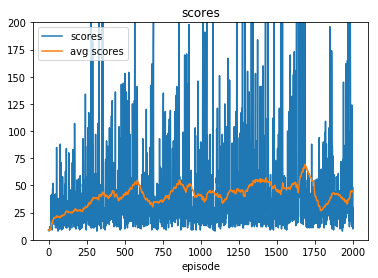

In [4]:
import matplotlib.pyplot as plt
plt.plot(scores)
plt.plot(avg_scores)
plt.xlabel('episode')
plt.legend(['scores', 'avg scores'])
plt.title('scores')
plt.ylim(0, 200)
plt.show()

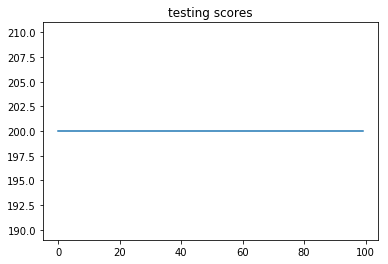

In [5]:
# 模型测试 ，可以看到testing scores在100次测试中均为200，说明模型已经完全掌握了这个简单的游戏
# 模型读取
# model_state_dict = paddle.load("mu.pdparams")
# mu.set_state_dict(model_state_dict)

import matplotlib.pyplot as plt
tests = 100
scores = []
mu.eval()
for episode in range(tests):
    obs = env.reset()
    done = False
    score = 0
    while not done:
        a = choose_action(env, evaluate=True)      
        obs_, r, done, _ = env.step(a)
        score += r
        obs = obs_
    scores.append(score)
plt.plot(scores)
plt.title('testing scores')
plt.show()

写在最后：
* MuZero 能够对规则、环境进行建模， 与此同时它还能学会规则，这就是它的最大创新。也是因为这个，MuZero的搜索空间变得更大，所以计算量会大大增加，但理论上仍旧是强化学习。
* 人类世界中的规则随时在变化，那么显然 Muzero 相比二代 AlphaZero 具有更好的生存能力。可以看到的是，Muzero 有潜力成为广泛使用的强化学习算法。
* 后续有计划在Atari、Gomoku、Tic-tac-toe 等环境下复现Muzero算法
